# As the data is intimedataing for new people to images analysis (like me !) I created this notebook which aims to understand data and make a first submission

### 1. Install this packages for correctly reading images (credit : [this notebook of @samuelcortinhas](https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda))
## BUT BEFORE YOU HAVE TO ADD pydicom utility : Add Data menu --> search for Pydicom Utility --> add the data

In [16]:
!pip install -qU '../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl' --find-links frozen_packages --no-index


In [17]:
!pip install -qU '../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl' --find-links frozen_packages --no-index

In [18]:
!head ../input/rsna*/train.csv



StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0


### 2. Import the necessary packages

In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
import nibabel as nib
import random

### 3. Explore the csv files : train.csv and train_bounding_boxes

#### Read train.csv

In [20]:
train = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train.csv')
print(train.info())
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  2019 non-null   object
 1   patient_overall   2019 non-null   int64 
 2   C1                2019 non-null   int64 
 3   C2                2019 non-null   int64 
 4   C3                2019 non-null   int64 
 5   C4                2019 non-null   int64 
 6   C5                2019 non-null   int64 
 7   C6                2019 non-null   int64 
 8   C7                2019 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 142.1+ KB
None


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


#### Let's create a function that returns a list of the fractured bones of a given id. We may need it later

In [21]:
def get_fractured_bones(patient_id):
    fractured_bones = []
    temp = train.loc[train.StudyInstanceUID == patient_id,['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
    temp = list(temp.values[0]) # there is one row per id
    for i in range(len(temp)):
        if temp[i] == 1:
            fractured_bones.append('C' + str(i+1))
    return fractured_bones

In [22]:
# Test the function
get_fractured_bones('1.2.826.0.1.3680043.6200')

['C1', 'C2']

#### Read train_bounding_boxes

In [23]:
#!ls ../input/rsna*/*
train_bb = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')
print(train_bb.info())
train_bb.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7217 entries, 0 to 7216
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StudyInstanceUID  7217 non-null   object 
 1   x                 7217 non-null   float64
 2   y                 7217 non-null   float64
 3   width             7217 non-null   float64
 4   height            7217 non-null   float64
 5   slice_number      7217 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 338.4+ KB
None


,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
5,1.2.826.0.1.3680043.10051,213.56364,216.71419,25.13455,47.92717,138
6,1.2.826.0.1.3680043.10051,209.00000,214.57591,36.06131,51.56834,139
7,1.2.826.0.1.3680043.10051,204.25455,212.24727,47.47636,57.71635,140
8,1.2.826.0.1.3680043.10051,205.00000,213.87342,45.00000,59.12658,141
9,1.2.826.0.1.3680043.10051,205.18545,214.76814,42.89892,63.43364,142


#### What's the link with train.csv ?<br>
First, the StudyInstanceUID column is present in both files (later on we will call it id)<br> 
But, not all ids present in train are also present in train_bb, because train_bb contains only fractured bones.<br>
Let's check that :

In [24]:
# get fractured and unfractured ids from train
fractured_ids = list(train.loc[train['patient_overall']==1,:]['StudyInstanceUID'])
unfractured_ids = list(train.loc[train['patient_overall']==0,:]['StudyInstanceUID'])
train_ids = fractured_ids + unfractured_ids
print('Number of ids from train : ', len(train_ids))
print('Number of unfractured ids from train : ', len(unfractured_ids))
print('Number of fractured ids from train : ', len(fractured_ids))

# get ids from train_bb
ids_bb = train_bb['StudyInstanceUID'].unique()
print('Number of ids in train_bb : ', len(ids_bb))

# print ids not in train_bb
ids_not_in_train_bb = [i for i in train_ids  if not i in ids_bb]
unfr_ids_not_in_train_bb = [i for i in unfractured_ids  if not i in ids_bb]
fr_ids_not_in_train_bb = [i for i in fractured_ids  if not i in ids_bb]
print('Number of ids not in train_bb : ', len(ids_not_in_train_bb))
print('Number of unfractered ids not in train_bb : ', len(unfr_ids_not_in_train_bb))
print('Number of fractered ids not in train_bb : ', len(fr_ids_not_in_train_bb))

Number of ids from train :  2019
Number of unfractured ids from train :  1058
Number of fractured ids from train :  961
Number of ids in train_bb :  235
Number of ids not in train_bb :  1784
Number of unfractered ids not in train_bb :  1058
Number of fractered ids not in train_bb :  726


In [25]:
for x in ids_bb:
    if not x in  fractured_ids:
        print("ERR")
    #else:
        #print ("OK")

#### From line 2 and line 6, we can conclude that train_bb concerns only fractured bones.
#### But from a total of 961 fractured bones (line 3), train_bb contains only 235 (line 4)

Second, slice number refers to a dcm file present in the folder with the same name as the coressponding id. For example for the first line of train_bb with id = '1.2.826.0.1.3680043.10051' and slice_number = 133, we can check that there is a 133.dcm file in **'../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051'**<br>
This file is an image that we can read like this : 

In [26]:
!ls ../input/rs*/tra*ges/*10051

1.dcm	 127.dcm  155.dcm  183.dcm  210.dcm  239.dcm  267.dcm  5.dcm   78.dcm
10.dcm	 128.dcm  156.dcm  184.dcm  211.dcm  24.dcm   268.dcm  50.dcm  79.dcm
100.dcm  129.dcm  157.dcm  185.dcm  212.dcm  240.dcm  269.dcm  51.dcm  8.dcm
101.dcm  13.dcm   158.dcm  186.dcm  213.dcm  241.dcm  27.dcm   52.dcm  80.dcm
102.dcm  130.dcm  159.dcm  187.dcm  214.dcm  242.dcm  270.dcm  53.dcm  81.dcm
103.dcm  131.dcm  16.dcm   188.dcm  215.dcm  243.dcm  271.dcm  54.dcm  82.dcm
104.dcm  132.dcm  160.dcm  189.dcm  216.dcm  244.dcm  272.dcm  55.dcm  83.dcm
105.dcm  133.dcm  161.dcm  19.dcm   217.dcm  245.dcm  28.dcm   56.dcm  84.dcm
106.dcm  134.dcm  162.dcm  190.dcm  218.dcm  246.dcm  29.dcm   57.dcm  85.dcm
107.dcm  135.dcm  163.dcm  191.dcm  219.dcm  247.dcm  3.dcm    58.dcm  86.dcm
108.dcm  136.dcm  164.dcm  192.dcm  22.dcm   248.dcm  30.dcm   59.dcm  87.dcm
109.dcm  137.dcm  165.dcm  193.dcm  220.dcm  249.dcm  31.dcm   6.dcm   88.dcm
11.dcm	 138.dcm  166.dcm  194.dcm  221.dcm  25.dcm   32.dcm   60.dcm

In [27]:
# path of train images
path_ti = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
# some id
id1 = '1.2.826.0.1.3680043.10051'
# some slice of that id
slice_number = 142
# Read the file of that id and that slice number
dicom_file = pydicom.dcmread(path_ti + '/' + id1 + '/' + str(slice_number) + '.dcm')
# print dicome_file
print(dicom_file)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10051.1.142
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10051.1.142
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183727.596747'
(0010, 0010) Patient's Name                      PN: '10051'
(0010, 0020) Patient ID                          LO: '10051'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

#### We can plot the image from the pixel_array field like this :

In [28]:
# get the image as an array
dicom_file_arr = dicom_file.pixel_array
print('sahpe of array image : ', dicom_file_arr.shape)
#dicom_file_arr[0][0]

sahpe of array image :  (512, 512)


##### Plot the image and the bounding boxe :

In [29]:
# get bounding box for id1 and slice_number as a list
if id1 in ids_bb:
    print("id1 in ids_bb")
bounding_boxe = train_bb.loc[(train_bb.StudyInstanceUID == id1) & (train_bb.slice_number == slice_number), :]
bounding_boxe = list(bounding_boxe.values[0])
x = bounding_boxe[1] # x-coordinate of the top left of the boxe
y = bounding_boxe[2] # y-coordinate of the top left of the boxe
w = bounding_boxe[3] # width of the boxe
h = bounding_boxe[4] # height of the boxe
# Create a Rectangle patch to add later to the figure
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor="none") # (x, y), width, height

#Define figure and axes
#fig, ax = plt.subplots(1,1, figsize=(10,10))
# add the image
#ax.imshow(dicom_file_arr, cmap=plt.cm.bone)
# Add the boxe
#ax.add_patch(rect)
# diplay
#plt.show()


id1 in ids_bb


##### From train.csv we can get fractured bones for that id :

In [30]:
str(get_fractured_bones(id1))

"['C4']"

##### We have only one fractured bone (C4) but we have 16 bounding boxes !! :

In [31]:
!head ../input/rs*/test.csv

row_id,StudyInstanceUID,prediction_type
1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [32]:
bounding_boxes_id1_df = train_bb.loc[(train_bb.StudyInstanceUID == id1) , :]
bounding_boxes_id1_df

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
5,1.2.826.0.1.3680043.10051,213.56364,216.71419,25.13455,47.92717,138
6,1.2.826.0.1.3680043.10051,209.00000,214.57591,36.06131,51.56834,139
7,1.2.826.0.1.3680043.10051,204.25455,212.24727,47.47636,57.71635,140
8,1.2.826.0.1.3680043.10051,205.00000,213.87342,45.00000,59.12658,141
9,1.2.826.0.1.3680043.10051,205.18545,214.76814,42.89892,63.43364,142


##### So let's plot all of these, but by defining a function that we can use later :

In [33]:
def plot_16_first_slices(patient_id, MAX_PLOTS = 16, plot_size = (20, 20)):
    
    # get bounding boxes for that id (it may be empty !)
    bounding_boxes_df = train_bb.loc[(train_bb.StudyInstanceUID == patient_id) , :].head(MAX_PLOTS).reset_index() # reset_index to get indexes starting from 0
    
    # number of slices
    n = len(bounding_boxes_df)
    
    if n == 0:
        return
    
    # number of rows and columns for the fig
    n_rows = int(np.sqrt(n))
    n_cols = n // n_rows
    
    if n_rows * n_cols < n:
        n_cols = n_cols + 1
        
    # define the subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=plot_size)
    fig.suptitle('ID : '+ patient_id + ' - Fractured bones : ' + str(get_fractured_bones(patient_id)), fontsize=16)
    
    

    for row_index,row in bounding_boxes_df.iterrows():
        # Create a Rectangle patch to add later to the figure
        rect = patches.Rectangle((row.x, row.y), row.width, row.height, linewidth=2, edgecolor='r', facecolor="none") # (x, y), width, height
        # read the image
        dicom_file = pydicom.dcmread(path_ti + '/' + row.StudyInstanceUID + '/' + str(row.slice_number) + '.dcm')
        dicom_file_arr = dicom_file.pixel_array
        # add the image
        i = row_index // n_cols
        j = row_index % n_cols
        ax[i, j].imshow(dicom_file_arr, cmap=plt.cm.bone)
        # Add the boxe
        ax[i, j].add_patch(rect)
        #title
        ax[i, j].set_title('Slice : {}'.format(str(row.slice_number)), fontsize = 14)
        
    # diplay
    plt.show()

In [34]:
# plot for id1
#plot_16_first_slices(id1)

In [35]:
# plot for another id where fractured bones are C4 and C5
id2 = '1.2.826.0.1.3680043.9940'
#plot_16_first_slices(id2)

##### Now, what about segmentation ?<br>
##### These files are very special as they contain many images. We can get data from them as array like this :

In [36]:
path = '../input/rsna-2022-cervical-spine-fracture-detection/segmentations/'
id3 = '1.2.826.0.1.3680043.10633'
segmentations = nib.load( path + id3 + '.nii').get_fdata()

In [37]:
segmentations.shape

(512, 512, 429)

##### But to get the right orientation of the image we must do this transformation :
[See this discution of Harshit Sheoran.](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612)

In [38]:
segmentations = segmentations[:, ::-1, ::-1] # invserse orientation of dim 1 and 2

segmentations = segmentations.transpose(2, 1, 0) # then switch dim 0 with dim 2

print(segmentations.shape)

(429, 512, 512)


[](http://)

In [39]:
#fig, ax = plt.subplots(1,1, figsize=(8,8))
#ax.imshow(segmentations[0], cmap=plt.cm.bone)
#plt.show()

##### There is noting in this image ! 
##### and we can see that many of the first images contains nothing
##### Let's plot other ones at random begining from position 200:

In [40]:
seg = [i for i in range(200, 300)]  #random.sample(range(200,300), 16)

#fig, ax = plt.subplots(4,4, figsize=(20,20))

for i in range(16):
    r = i // 4
    c = i % 4
    #ax[r, c].imshow(segmentations[seg[i],:,:], cmap=plt.cm.bone)
    
#plt.show()

#### What we'll see if we sum up all these sementations :

In [41]:
temp = segmentations[0,:,:]
for i in range(segmentations.shape[0]):
    temp = temp + segmentations[i,:,:]


#fig, ax = plt.subplots(1,1, figsize=(10,10))
#ax.imshow(temp, cmap=plt.cm.bone)


#plt.show()

##### Let's define a function so we can try another ids

In [42]:
def plot_nii_files(patient_id, seg_order = None, plot = True):
    path = '../input/rsna-2022-cervical-spine-fracture-detection/segmentations/'
    segmentations = nib.load( path + patient_id + '.nii').get_fdata()[:, ::-1, ::-1].transpose(2, 1, 0)
    
    if seg_order == None:
        img = segmentations[0,:,:]
        for i in range(segmentations.shape[0]):
            img = img + segmentations[i,:,:]
    else:
        img = segmentations[seg_order,:,:]
        
    if plot :
        # plot the image
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        ax.imshow(img, cmap=plt.cm.bone)
        plt.show()
    else:
        return img
    
    

In [43]:
id4 = '1.2.826.0.1.3680043.19333'
#plot_nii_files(id4)

### Let's prepare data for a Conv2D model

##### First define a function that return a number of image for a number of ids and there labels :

In [44]:
cols = ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] # for labels

def get_train_images(train_df, n_ids = 10, n_img = 10, img_size = (32,32)):
    
    train_images = []
    train_labels = []
    
    # get n_ids ids at random
    ids = random.sample(list(train_df['StudyInstanceUID'].values), n_ids)
    
    
    for id_ in ids:
        # get labels for tha id_
        labels = train_df.loc[train_df['StudyInstanceUID'] == id_, cols].values[0]
        # label C1-C7 fracture or not, print(labels)
        # file names of that id_
        id_files = os.listdir(path_ti + '/' + id_)
         
        # read each of the dcm files
        for i in range(min(len(id_files), n_ids)):
            image = pydicom.dcmread(path_ti + '/' + id_ + '/' + id_files[i]).pixel_array
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            train_images.append(image)
            # add labels train_labels
            train_labels.append(labels)
    return np.array(train_images), np.array(train_labels)

            
            

##### Now a function that yields this images (will be needed later)

In [45]:
def generate_train_images(train_df, n_ids = 10, n_img = 10, img_size = (32, 32)):
    while 1:
        yield get_train_images(train_df, n_ids , n_img , img_size )

#### The Model (a simple one !) 

In [46]:
# import libraries
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras

In [47]:
#gpu related
#os.environ['TFF_CPP_MIN_LOG_LEVEL']='2'
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-09-22 06:39:52.786568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 06:39:52.882918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 06:39:52.883828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [48]:
def get_model():
    
    img_input = layers.Input(shape=(32, 32,1))

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv2D(16, 3, activation='relu')(img_input)
    x = layers.MaxPooling2D(2)(x)

    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x = layers.Flatten()(x)

    # Create output layer with a single node and sigmoid activation
    output = layers.Dense(8, activation='sigmoid')(x)


    # Create model:
    model = Model(img_input, output)
    
    return model

In [49]:
model = get_model()

2022-09-22 06:39:52.957177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 06:39:52.957641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 06:39:52.958527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 06:39:52.959189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 28808     
Total params: 28,968
Trainable params: 28,968
Non-trainable params: 0
_________________________________________________________________


Loss function for competition.


In [51]:
def CustomMSE(y_true, y_pred):
    neg = tf.constant([[1, 1, 1, 1, 1, 1, 1, 7]],dtype=tf.float32)
    pos = neg*2
    eps=1E-8 
    
    #y_true=tf.cast(y_true,tf.float32)
    #y_pred=tf.cast( y_pred,tf.float32)
    
    y_pred=tf.math.maximum(eps,tf.math.minimum(1-eps, y_pred))
    
   
    
    L=tf.cast(y_true,tf.float32)*tf.math.log( y_pred)+(1.0-tf.cast(y_true,tf.float32))*tf.math.log(1- y_pred)
        
        #print(y_true.shape)
        #pos=tf.broadcast_to(pos,y_true)
        #neg=tf.broadcast_to(neg,y_true)
        
    w=pos*tf.cast(y_true,tf.float32)+neg*(1-tf.cast(y_true,tf.float32))
        #print(tf.reduce_sum(L*w,1))
        #print(tf.reduce_sum(w,1))
    return -( tf.reduce_sum(L*w,1)/tf.reduce_sum(w,1) ) 


https://www.kaggle.com/code/vslaykovsky/train-pytorch-effnetv2-baseline-cv-0-49/notebook

loss tensor([[2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [0.1054, 2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
       
all weights tensor([[14.,  2.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 7.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], device='cuda:0')
        
weighted loss tensor([[32.2362,  0.2107,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054],
        [ 0.7375,  2.3026,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054]],
       device='cuda:0')
       
normalization factors tensor([[22.],
        [14.]], device='cuda:0')
        
normalized loss tensor([[1.4653, 0.0096, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048],
        [0.0527, 0.1645, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075]],
       device='cuda:0')
       
summed up over patient_overall-C1-C7 loss tensor([1.5036, 0.2623], device='cuda:0')

In [52]:
y_test1=[[ 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1],
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1] ]
 
y_true1=[
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0, 0., 0., 0., 0., 0., 0.]
    ]
CustomMSE(y_true1,y_test1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5035943, 0.2623051], dtype=float32)>

Our CustomMSE delivers competition metric! 

In [53]:
tmp= get_train_images(train,10,10)
X=tmp[0]
Y=tmp[1] 
    
model = get_model()
model.summary()
model.compile( loss=CustomMSE , #competition_loss,
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 28808     
Total params: 28,968
Trainable params: 28,968
Non-trainable params: 0
_________________________________________________________________


In [54]:
#history = model.fit(X,Y, steps_per_epoch = 10, epochs = 1) #delete

In [55]:
# count the total number of image
#n_train_images = 0  
#for id_ in train['StudyInstanceUID']:
#  n_train_images = n_train_images + len(os.listdir(path_ti + '/' + id_))
#print(n_train_images)

#n_train_images = 711601

In [56]:

#history = model.fit(generate_train_images(train,3,3), steps_per_epoch = 6, epochs = 1)

#bce(Y,model.predict(X)) 

#history = model.fit(generate_train_images(train,30,30), steps_per_epoch = 6, epochs = 1)#100 100

In [57]:
def get_test_images(img_size = (32, 32)):
    path = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
    test_images = []
    test_ids = []
    # test ids
    ids = os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/test_images')
    print(ids)
    
    for id_ in ids:
        # file names of that id_
        id_files = os.listdir(path + '/' + id_)
        # read each of the dcm files
        for i in range(len(id_files)):
            image = pydicom.dcmread(path + '/' + id_ + '/' + id_files[i]).pixel_array
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            test_images.append(image)
            # add id_ to test_ids
            test_ids.append(id_)
    
    return np.array(test_images), np.array(test_ids)
    

In [58]:
# test the function
#test_images, test_ids = get_test_images()

In [59]:
#results = model.predict(test_images)

In [60]:
#results_df = pd.DataFrame(data=results, columns=cols)
#results_df.insert(0, 'patient_id', np.array(test_ids))
#results_df = results_df.melt(id_vars='patient_id', value_vars=cols, var_name='bone', value_name='fractured')
#results_df.insert(0, 'row_id', results_df.patient_id + '_' + results_df.bone)
#results_df.drop(['patient_id', 'bone'], axis=1, inplace=True)
#results_df = pd.DataFrame(results_df.groupby(['row_id']).max().reset_index())
#results_df.head(30)

**3D CNN MODEL**

In [61]:
def get_cut(id_files, num=32):  #get appropriate 32 2D cuts for single patient
    x = []
    x_32 = []
    
    for nam in id_files:
        x.append(int(nam.split('.')[0]))
    x.sort()
    x_len=len(x)
    
    # get 32 cut out of all cuts
    for i in range(32):
        x_32.append(x[ min(x_len-1,i*min(x_len/32,1))])
    
    return x_32

def get_train_images_3D(train_df, n_ids = 10, n_img = 10, img_size = (64,64)):
    
    train_images = []
    train_labels = []
    
    # get n_ids ids at random
    ids = random.sample(list(train_df['StudyInstanceUID'].values), n_ids)
    
    
    for id_ in ids:
        # get labels for tha id_
        labels = train_df.loc[train_df['StudyInstanceUID'] == id_, cols].values[0]
        # label C1-C7 fracture or not, print(labels)
        # file names of that id_
        id_files = os.listdir(path_ti + '/' + id_) 
        cas = []  # a 3D tensor for a patient scan
        cuts = get_cut(id_files,32)  # index of 32 cuts
        
        # read each of the dcm files
        for i in range(32):
            image = pydicom.dcmread(path_ti + '/' + id_ + '/' + str(cuts[i])+'.dcm').pixel_array
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            cas.append(image)
           # print(np.array(cas).shape)
            # add labels train_labels
        train_images.append(cas)   
        train_labels.append(labels)
    return train_images, train_labels
a=get_train_images_3D(train,6,6)
(tf.convert_to_tensor(a[0],dtype=tf.float32)).shape


TensorShape([6, 32, 64, 64])

In [171]:
def get_model_3D():
    
    img_input = layers.Input(shape=(32,64,64,1))

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv3D(32, 3, activation='relu')(img_input)
   # x = layers.MaxPooling3D(2)(x)
   
    xt = layers.Conv3D(24, 3, activation='relu')(x)
    
    x2 = layers.Conv3D(16, 3, activation='relu')(x)
    x2 = layers.MaxPooling3D(2)(x2)
    
    x3 = layers.Conv3D(12, 3, activation='relu')(x2)
    x3 = layers.MaxPooling3D(2)(x3)
    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x3 = layers.Flatten()(x3)

    # Create output layer with a single node and sigmoid activation
    output = layers.Dense(8, activation='sigmoid')(x3)


    # Create model:
    model = Model(img_input, output)
    
    return model

In [182]:
#tmp= get_train_images_3D(train,200,200) 
#X=tf.convert_to_tensor(tmp[0], dtype=tf.float32)
#Y=tf.convert_to_tensor(tmp[1], dtype=tf.float32)
from sklearn.model_selection import train_test_split
X,Y = get_train_images_3D(train,400,400)
tmp2 = train_test_split(X, Y,test_size=0.1)#train_X, val_X, train_Y, val_Y = train_test_split(X, Y)

train3D_X = (tf.convert_to_tensor(tmp2[0],dtype=tf.float32))
val3D_X = (tf.convert_to_tensor(tmp2[1],dtype=tf.float32))

train3D_Y = (tf.convert_to_tensor(tmp2[2],dtype=tf.float32))
val3D_Y = (tf.convert_to_tensor(tmp2[3],dtype=tf.float32))
#print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape)

In [183]:
def model_3D_getfit(A,B):
    tf.keras.backend.clear_session()
    model = get_model_3D()
    model.summary()
    model.compile( loss=CustomMSE , #competition_loss,
                # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])


    history = model.fit(A,B, validation_split=0.25, epochs = 10) #delete
    return model, history

In [184]:
model_3D, history_3D = model_3D_getfit(train3D_X,train3D_Y)
print("loss for validation data = ")
val3D_prediction=model_3D.predict(val3D_X)
val_3D_loss = tf.reduce_mean(CustomMSE(val3D_Y,val3D_prediction),keepdims=False)
print(val_3D_loss)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 64, 64, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 30, 62, 62, 32)    896       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 60, 60, 16)    13840     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 30, 30, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 12, 28, 28, 12)    5196      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 14, 14, 12)     0         
_________________________________________________________________
flatten (Flatten)            (None, 14112)             0     

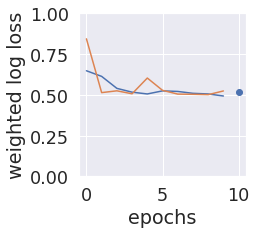

In [185]:
#Define figure and axes
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.set_ylim(ymin=0)
plt.xlabel("epochs")
plt.ylabel("weighted log loss")

# add the image
#print(history_3D.history )
plt.plot(history_3D.history['loss'])

plt.plot(history_3D.history['val_loss'])
plt.scatter(len(history_3D.history['val_loss']),val_3D_loss)
#plt.scatter(10,history_3D.history['loss'][0])
# Add the boxe
#res=[]
res.append([300,history_3D.history['loss'],(history_3D.history['val_loss'])])
# diplay
plt.show()

# x 3D images, 10% for evaluation, 75%(25%) of the rest images for train(validation).
# One can see over fitting >10 epochs

x = 300 3D images, 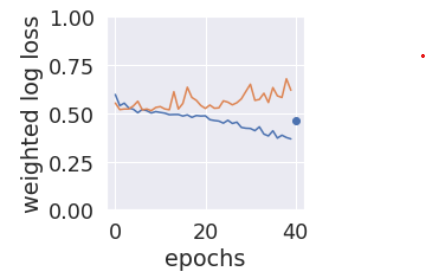

x = 400 3D images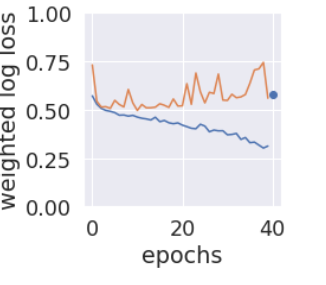

x = 500 3D images
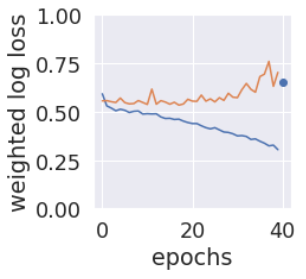

# x = 300 images & 10 epochs work best

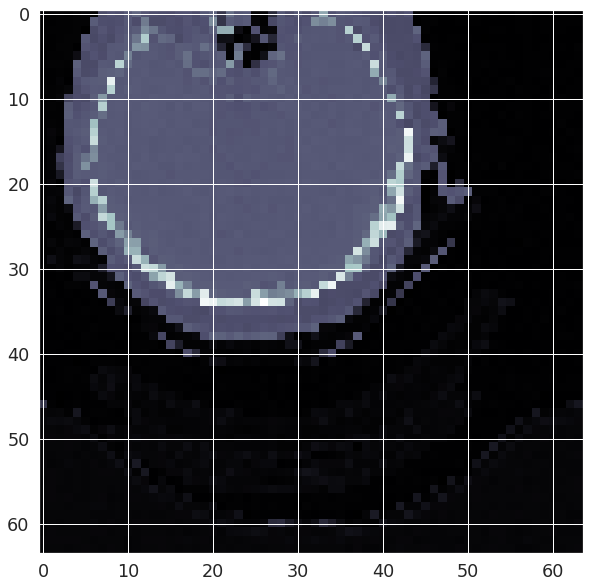

In [187]:

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(X[0][1], cmap=plt.cm.bone)


plt.show()

In [189]:
 
def get_test_images_3D( img_size = (64,64)):
    
    path = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
    test_images = []
    test_ids = []
     
    
    ids = os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/test_images')
    print("test images")
    print(ids)
    for id_ in ids: 
        # label C1-C7 fracture or not, print(labels)
        # file names of that id_
        id_files = os.listdir(path + '/' + id_)
         
            
        cuts = get_cut(id_files,32)  # index of 32 cuts
       
            
        cas = []
        # read each of the dcm files
        
        for i in range(min(32,len(id_files))):
            
            image = pydicom.dcmread(path + '/' + id_ + '/' +str(cuts[i])+'.dcm').pixel_array
        
                # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            cas.append(image)
           # print(np.array(cas).shape)
            # add labels train_labels
        test_images.append(cas)    
        test_ids.append(id_)
    return test_images, test_ids
#try it out
#a=get_test_images_3D()
#(tf.convert_to_tensor(a[0],dtype=tf.float32)).shape

    

In [190]:
# test the function
test_images_3D, test_ids_3D = get_test_images_3D()
X_test=tf.convert_to_tensor(test_images_3D, dtype=tf.float32)

results_3D = model_3D.predict(X_test)
 

test images
['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876']


#### Prepare the submission file

In [191]:
results_df_3D = pd.DataFrame(data=results_3D, columns=cols)
results_df_3D.insert(0, 'patient_id', np.array(test_ids_3D))
results_df_3D = results_df_3D.melt(id_vars='patient_id', value_vars=cols, var_name='bone', value_name='fractured')
results_df_3D.insert(0, 'row_id', results_df_3D.patient_id + '_' + results_df_3D.bone)
results_df_3D.drop(['patient_id', 'bone'], axis=1, inplace=True)
results_df_3D = pd.DataFrame(results_df_3D.groupby(['row_id']).max().reset_index())
results_df_3D.head(30)

,row_id,fractured
0,1.2.826.0.1.3680043.22327_C1,0.132436
1,1.2.826.0.1.3680043.22327_C2,0.245293
2,1.2.826.0.1.3680043.22327_C3,0.027883
3,1.2.826.0.1.3680043.22327_C4,0.114625
4,1.2.826.0.1.3680043.22327_C5,0.120406
5,1.2.826.0.1.3680043.22327_C6,0.219500
6,1.2.826.0.1.3680043.22327_C7,0.390011
7,1.2.826.0.1.3680043.22327_patient_overall,0.536404
8,1.2.826.0.1.3680043.25399_C1,0.013219
9,1.2.826.0.1.3680043.25399_C2,0.109316


In [192]:
results_df_3D.to_csv('submission.csv', index=False)